# Step 0: Imports and loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
pd.set_option('display.max_columns', 500)

In [2]:
data = pd.read_excel('Competition1_raw_data.xlsx')

In [18]:
data.head(3)

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10.0,9.5,8.5,11.87,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8.0,10.0,8.0,7.25,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7.0,14.0,12.0,6.70,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0


# DATA DISCREPENCIES/FINDINGS (Other Than Nulls or Zeros):

1) This company has a space in front of the name in I2 Column - Company Name
*  METABASIS THERAPEUTICS INC

Resolution: Remove Space

2) These 4 companies all have >1 Standard Industry Classifiers instead of 1 like the rest of the data set. 

* DTS, INC.
* RealD Inc.
* Dolby Laboratories, Inc.
* UNIVERSAL POWER GROUP 

Resolution: Select just 1 Standard Industry Classifier

3) These 2 companies have Price Range Higher Bound > than Price Range Lower Bound. Which does not make sense

* Kips Bay Medical, Inc.
* NPTEST HOLDING CORP

Resolution: Replace the P(H) which looks to be incorrect. Replace with the P(L) for consistency.

4) These 2 companies have First Day of Trading Prices way too high to keep included in the model. 

* OCEANFREIGHT INC.
* NeuroMetrix, Inc.

Resolution: Drop and replace with Null as they are outliers that would cause too much error in the model.

5) This company had 246 sentances in their Prospectus MD&A Section, but just 527 words. If we divide words/sentances, this would mean each sentance has about 2 words per sentance, which isn't enough to qualify as a sentance. The company also has 9,046 real words, which is way more than 527 "words" shown in column T2.

* KKR Financial Holdings LLC

Resolution: Replace the T2 column which looks to be incorrect.

6) This company had -1 positive words in their prospectus.

* Cogent, inc.

Resolution: Drop this value and replace with null as it make no sense to have a negative count of words.

# Step 1: Identify the null values

In [4]:
for col in data.columns:
    data[col] = data[col].apply(lambda x: None if x == '-' else x)

# Step 2: Descriptive Statistics
- Mean/median/std/min/max/count/quartiles
- Missing Records
- Outlier Identification
    - Address Outliers
- Data Types/Fix data types

In [5]:
data.describe()

,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
count,677.000000,672.000000,672.000000,660.000000,660.000000,660.000000,646.000000,660.000000,6.760000e+02,6.760000e+02,610.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000
mean,13.837666,15.481190,13.515045,25.934766,149.728788,0.859091,1.788904,0.007282,4.935776e+07,1.241519e+07,500.459962,465.634361,12758.606461,11395.844347,294.353891,679.220264,68.421439,120.104258,144.759178
std,6.053731,6.653429,5.835646,73.234948,152.817467,0.348192,162.666532,0.033318,1.043764e+08,2.512855e+07,1648.337634,175.741647,5449.644597,4839.670179,121.532637,472.914323,39.096525,84.828959,69.276285
min,3.000000,0.000000,3.000000,0.000000,10.000000,0.000000,-786.239000,-0.162352,3.693227e+06,5.250000e+05,0.074000,132.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,20.000000,26.000000
25%,10.000000,12.500000,11.000000,11.000000,85.000000,1.000000,-0.852500,-0.013927,1.871417e+07,5.000000e+06,37.245750,351.000000,9195.000000,8162.000000,213.000000,462.000000,45.000000,73.000000,100.000000
50%,13.500000,15.000000,13.000000,14.845000,107.000000,1.000000,0.010000,0.009125,2.740018e+07,7.398704e+06,103.833000,444.000000,12045.000000,10785.000000,279.000000,624.000000,60.000000,100.000000,134.000000
75%,17.000000,17.000000,15.000000,20.485000,155.250000,1.000000,0.470000,0.031571,4.980786e+07,1.200000e+07,331.138000,551.000000,15241.000000,13760.000000,354.000000,795.000000,85.000000,142.000000,173.000000
max,85.000000,135.000000,108.000000,1159.200562,2087.000000,1.000000,3864.500000,0.092896,2.138085e+09,4.212336e+08,30683.000000,1750.000000,49056.000000,43952.000000,1058.000000,10277.000000,309.000000,944.000000,883.000000


Counts of null values

In [6]:
pd.isna(data).sum()

I1          0
I2          0
I3          8
P(IPO)      5
P(H)       10
P(L)       10
P(1Day)    22
C1         22
C2         22
C3         36
C4         22
C5          6
C6          6
C7         72
T1          1
T2          1
T3          1
T4          1
T5          1
S1          1
S2          1
S3          1
dtype: int64

Data Types before being fixed (necessary due to the way nulls were given as a string initially)

In [7]:
data.dtypes

I1          object
I2          object
I3          object
P(IPO)     float64
P(H)       float64
P(L)       float64
P(1Day)    float64
C1         float64
C2         float64
C3         float64
C4         float64
C5         float64
C6         float64
C7         float64
T1         float64
T2         float64
T3         float64
T4         float64
T5         float64
S1         float64
S2         float64
S3         float64
dtype: object

Column:  P(IPO)


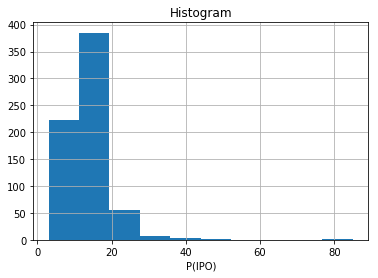

outliers low value < -4.323527564203351
outlier low count:  0
outliers high value > 31.9988599128001
outlier high count:  8


Column:  P(H)


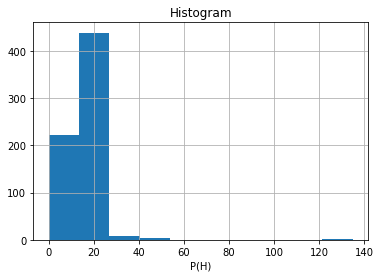

outliers low value < -4.479096534989019
outlier low count:  0
outliers high value > 35.44147748736997
outlier high count:  7


Column:  P(L)


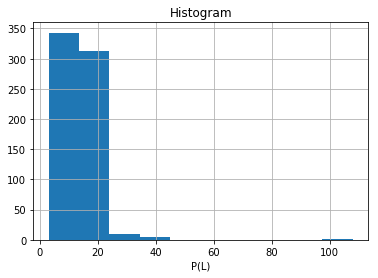

outliers low value < -3.9918926658603855
outlier low count:  0
outliers high value > 31.021981951574674
outlier high count:  7


Column:  P(1Day)


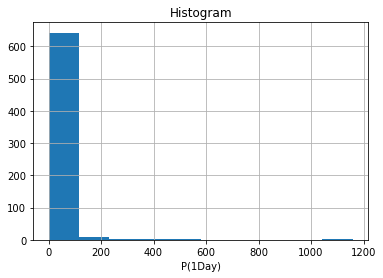

outliers low value < -193.77007737082823
outlier low count:  0
outliers high value > 245.63960966954545
outlier high count:  7


Column:  C1


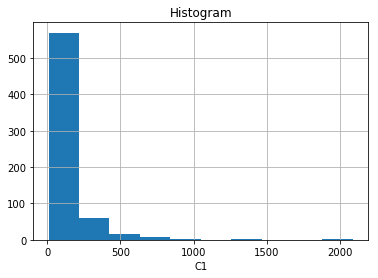

outliers low value < -308.72361320842344
outlier low count:  0
outliers high value > 608.1811889659992
outlier high count:  15


Column:  C2


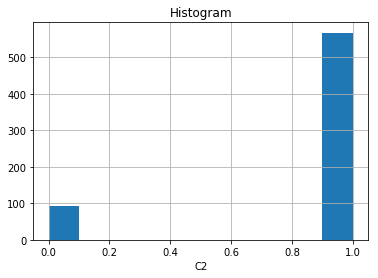

outliers low value < -0.1854839845914531
outlier low count:  0
outliers high value > 1.9036658027732714
outlier high count:  0


Column:  C3


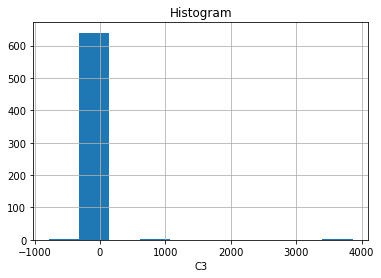

outliers low value < -486.21069148307134
outlier low count:  2
outliers high value > 489.788499532607
outlier high count:  2


Column:  C4


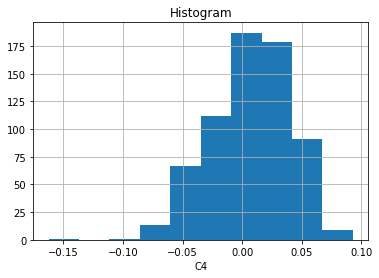

outliers low value < -0.09267073079434433
outlier low count:  2
outliers high value > 0.10723513361722141
outlier high count:  0


Column:  C5


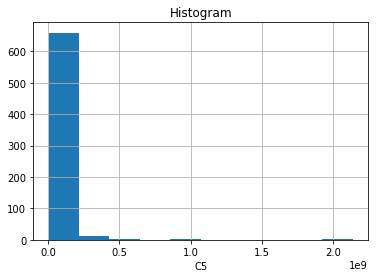

outliers low value < -263771547.09439728
outlier low count:  0
outliers high value > 362487065.78374636
outlier high count:  4


Column:  C6


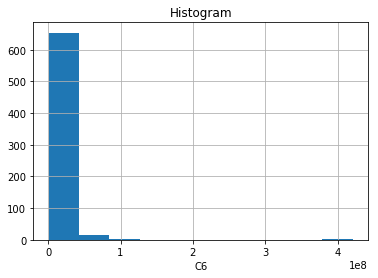

outliers low value < -62970469.94487368
outlier low count:  0
outliers high value > 87800858.40345356
outlier high count:  5


Column:  C7


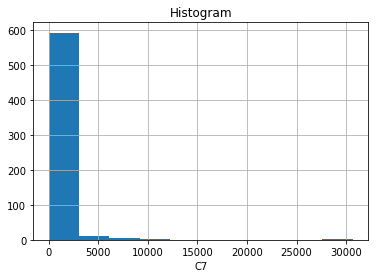

outliers low value < -4444.552940625089
outlier low count:  0
outliers high value > 5445.472865215253
outlier high count:  7


Column:  T1


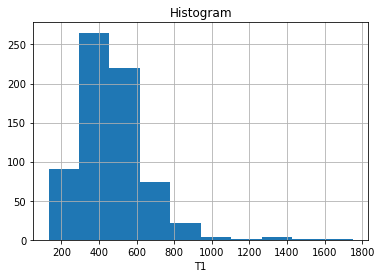

outliers low value < -61.59057904556391
outlier low count:  0
outliers high value > 992.8593015125242
outlier high count:  9


Column:  T2


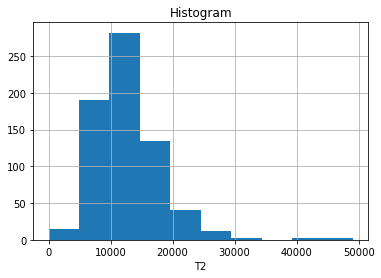

outliers low value < -3590.327329782169
outlier low count:  0
outliers high value > 29107.540251955445
outlier high count:  8


Column:  T3


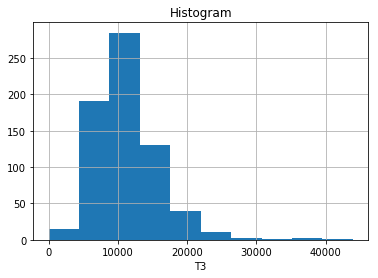

outliers low value < -3123.1661892108004
outlier low count:  0
outliers high value > 25914.854882309184
outlier high count:  9


Column:  T4


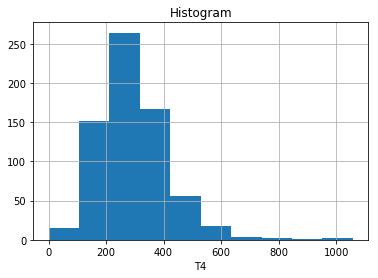

outliers low value < -70.2440205710713
outlier low count:  0
outliers high value > 658.9518032436117
outlier high count:  9


Column:  T5


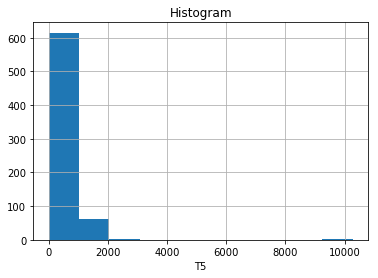

outliers low value < -739.5227059391386
outlier low count:  0
outliers high value > 2097.9632345735
outlier high count:  4


Column:  S1


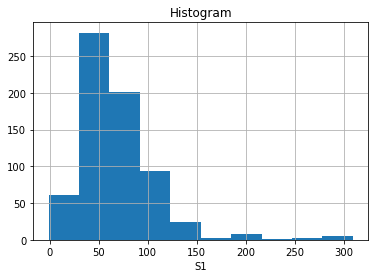

outliers low value < -48.86813737167449
outlier low count:  0
outliers high value > 185.71101549208566
outlier high count:  14


Column:  S2


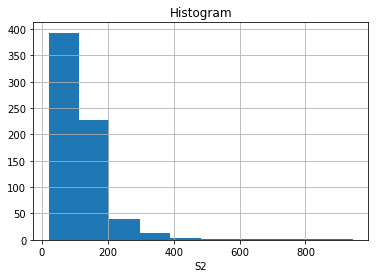

outliers low value < -134.3826196963994
outlier low count:  0
outliers high value > 374.5911365833304
outlier high count:  13


Column:  S3


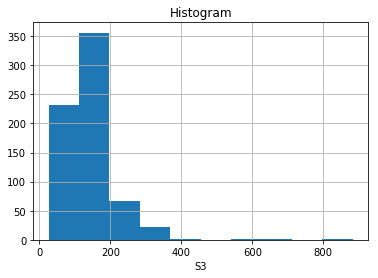

outliers low value < -63.06967776675194
outlier low count:  0
outliers high value > 352.58803312651696
outlier high count:  6




In [8]:
#Only plot numberical columns so drop non-numerical
for col in data.drop(['I1','I2','I3'],axis=1).columns:
    print("Column: ", col)
    
    #Create Histograms
    data[col].hist()
    plt.xlabel(col)
    plt.title('Histogram')
    plt.show()
    
    #Find outliers within 2 standard deviations of mean
    outliers_low = (data[col].mean() - 3*data[col].std())
    outliers_high = (data[col].mean() + 3*data[col].std())
    
    #Print outlier values and counts of how many outliers
    print("outliers low value <", outliers_low)
    print("outlier low count: ", data[col][data[col] < outliers_low].count())
    print("outliers high value >", outliers_high) 
    print("outlier high count: ", data[col][data[col] > outliers_high].count())
    print('\n')

# Step 3: Data Imputation
- Address null values dependent on the type of value in question
- Create a seperate column which shows whether or not imputation occurred

In [9]:
def impute_nulls_df(df, col, replace_val):
    '''
    params:
    
    df - dataframe containing nulls
    col - columns with nulls to replace
    replace_val - options: 'mean', 'median', 'mode'
    
    Example:

    imputed_data = impute_nulls(data, C1, 'mean')
    '''
    
    if replace_val not in ['mean','median','mode']:
        print('requires one of the following: mean, median, mode')
        return
    
    elif replace_val == 'mean':
        df[col + '_imputed'] = df[col].fillna(df[col].mean())
    elif replace_val == 'median':
        df[col + '_imputed'] = df[col].fillna(df[col].median())
    else:
        df[col + '_imputed'] = df[col].fillna(df[col].mode())
        
    return df

Create a dictionary for each value with the column and the type of imputation. Can then use a loop and the function above to impute them all.

In [10]:
# Example below
imputing = {
    'C1': 'mean',
    'C2': 'mean'
}

data_w_imputed = data.copy()

for key in imputing.keys():
    data_w_imputed = impute_nulls_df(data_w_imputed, key, imputing[key])

Now there are new imputed columns at the end of the dataframe

In [11]:
data_w_imputed

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,C1_imputed,C2_imputed
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10.0,9.5,8.5,11.870000,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,122.0,1.0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8.0,10.0,8.0,7.250000,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,259.0,0.0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7.0,14.0,12.0,6.700000,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,90.0,1.0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834,11.5,16.0,14.0,12.390000,209.0,1.0,-0.91,0.020023,14848637.0,4500000.0,8.526,328.0,8259.0,7574.0,177.0,509.0,80.0,59.0,110.0,209.0,1.0
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492,21.0,21.0,19.0,56.599998,80.0,1.0,0.07,-0.034895,30741716.0,8250000.0,632.298,572.0,14830.0,13176.0,336.0,720.0,67.0,149.0,167.0,80.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,ZIP,ZIPCAR INC,7514,18.0,16.0,14.0,28.000000,317.0,1.0,-0.37,0.004670,38386565.0,9684109.0,186.101,537.0,13359.0,12303.0,329.0,676.0,87.0,106.0,173.0,317.0,1.0
678,ZLTQ,Zeltiq Aesthetics Inc,3845,13.0,16.0,14.0,15.500000,98.0,1.0,-0.41,0.058689,32758082.0,7000000.0,25.461,496.0,13810.0,12515.0,321.0,784.0,70.0,126.0,173.0,98.0,1.0
679,ZSTN,"ZST Digital Networks, Inc.",3663,8.0,8.5,7.5,7.520000,112.0,0.0,0.60,0.030425,11479826.0,3125000.0,55.431,335.0,9067.0,8066.0,217.0,435.0,38.0,82.0,90.0,112.0,0.0
680,ZUMZ,Zumiez Inc,5600,19.0,17.0,15.0,12.435000,78.0,1.0,0.20,0.032284,13180261.0,3125000.0,117.857,256.0,7087.0,6445.0,182.0,306.0,48.0,38.0,100.0,78.0,1.0


# Step 4: Check Normality of fields

- Histogram
- Shapiro test for normality: a p-value of lower than 0.05 implies non-normal values

In [12]:
def check_normal_by_hist(df, col):
    '''
    Creates a histogram to view values to check normality
    
    params:
    df - DataFrame
    col - Columns of DataFrame you want to test
    
    return:
    Void, however will print a histogram
    
    '''
    df[col].hist()
    plt.show()
    
def check_normal_by_shapiro(df, col):
    '''
    Runs the Shapiro normality test on the values from a dataframe
    
    params:
    df - DataFrame
    col - Columns of DataFrame you want to test
    
    return:
    tuple - (Test Statistic, p-value)
    
    A p-value lower than 0.05 implies the values are NOT normal
    
    '''
    
    return shapiro(df[col].values)
    

Column:  P(IPO)


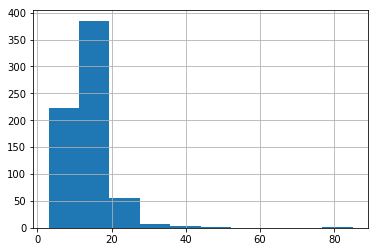

(nan, 1.0)


Column:  P(H)


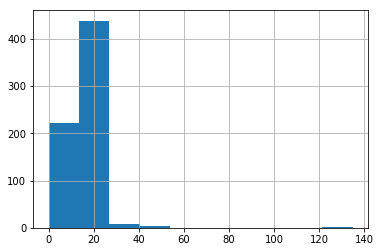

(nan, 1.0)


Column:  P(L)


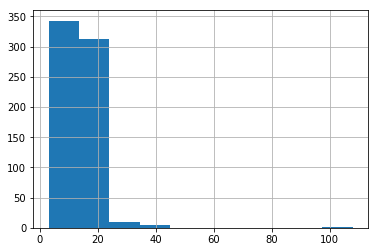

(nan, 1.0)


Column:  P(1Day)


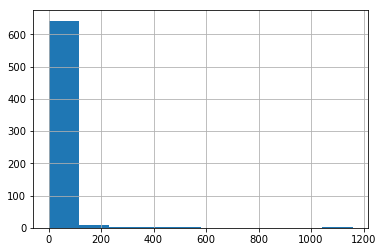

(nan, 1.0)


Column:  C1


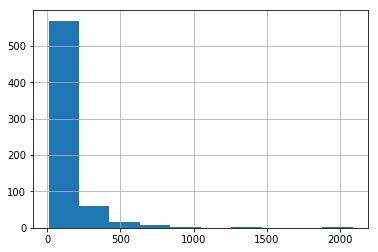

(nan, 1.0)


Column:  C2


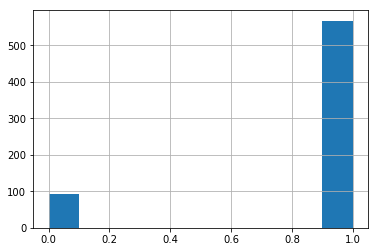

(nan, 1.0)


Column:  C3


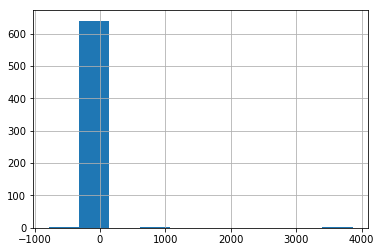

(nan, 1.0)


Column:  C4


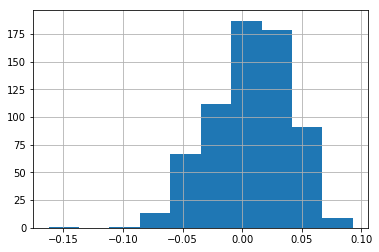

(nan, 1.0)


Column:  C5


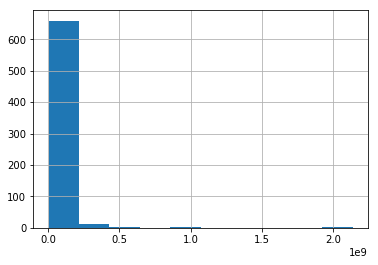

(nan, 1.0)


Column:  C6


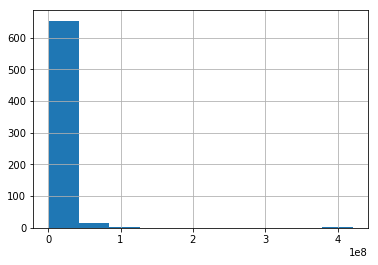

(nan, 1.0)


Column:  C7


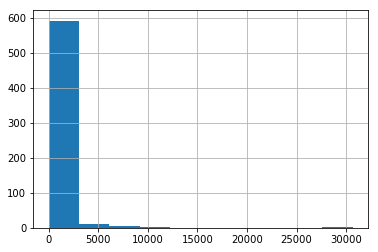

(nan, 1.0)


Column:  T1


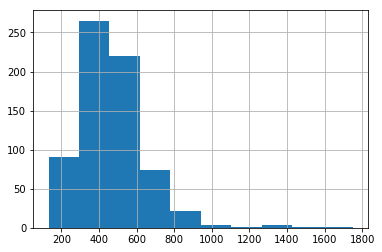

(nan, 1.0)


Column:  T2


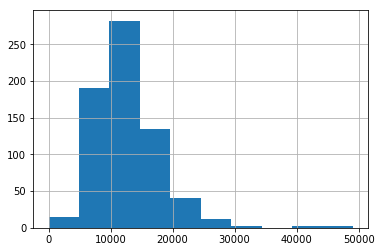

(nan, 1.0)


Column:  T3


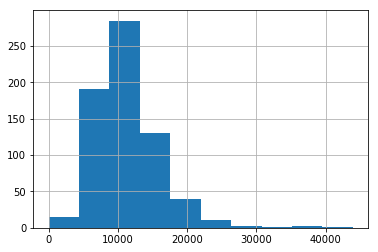

(nan, 1.0)


Column:  T4


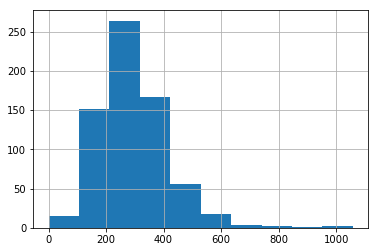

(nan, 1.0)


Column:  T5


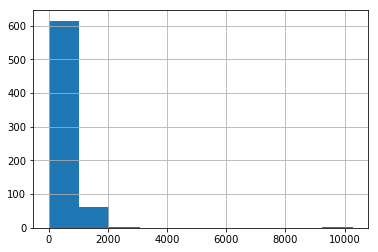

(nan, 1.0)


Column:  S1


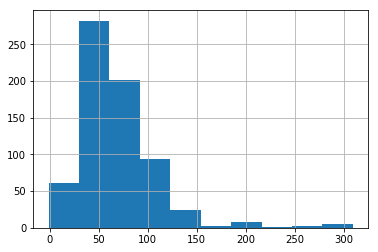

(nan, 1.0)


Column:  S2


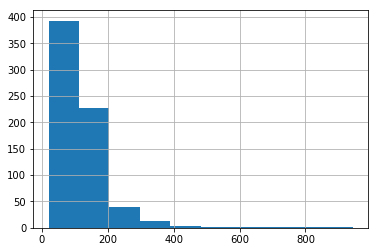

(nan, 1.0)


Column:  S3


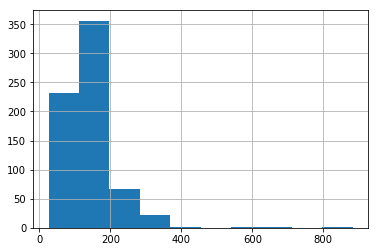

(nan, 1.0)


Column:  C1_imputed


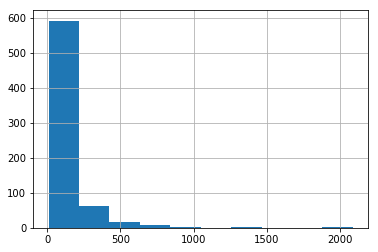

(0.5366458892822266, 7.148707300171482e-39)
Skewed


Column:  C2_imputed


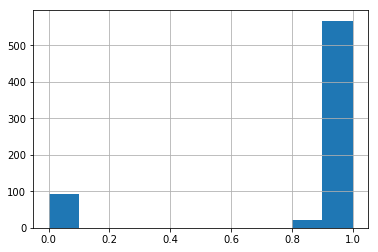

(0.4254383444786072, 6.615530050077461e-42)
Skewed




In [13]:
for col in data_w_imputed.drop(['I1','I2','I3'],axis=1).columns:
    print("Column: ", col)
    check_normal_by_hist(data_w_imputed, col)
    
    shap = check_normal_by_shapiro(data_w_imputed, col)
    print(shap)
    if shap [1]< 0.05:
        print('Skewed')

    print('\n')

# Step 4B: Create New Columns with Normalized values of non-normal fields
- Try applying squaring, log(), square root, 1/x function
- Leverage Histograms and Shapiro-Wilk test
- Or right to Z-Scoring

# Step 5B: Create values outlined in Data Dictionary
- T1-T5 as ratios
- S1-S3 as ratios
- C3', C5', C6'

Reference here: https://github.com/fairfield-university-ba545/project1-archana-s-team/blob/master/DataDictionary20190115.pdf

# Step 6: Correlation of input variables
- Line plot to display correlation
- HeatMap to check correlation

# Step 7A: Data Standardization (Continuous Values)
- Z-Score
- Min-Max Scaling
- Standard Scaler

- Save each type of scaling as seperate set


# Step 7B: Data Standardization (Categorical)
- Identify viable categories (create as few as possible)
- One-hot-encode if needed

# Step 8: Identify and remove redundunt information
- Leverage correlation analysis
- RFE (recursive feature elimination) to select valuable items
- JointPlots against target

# Step 8B: Balance Sample Data
- SMOTE
- Split Data

# Step 9: Test against sample code
- Test as-is to get baseline for AUC and F1 score
- Test different scaled data
- Test all data vs what we deem should be removed

# Step 10: Look at model specifics to seek room for improvement:
- Coefficiants of remaining fields
- Look at items with highest error rate and see if we can fit them to a class

# Step 11: Alternative Modeling techniques
- Random Forest
- Potentially XGBoost
- See if either of this yields better results